# Questions and answers pertaining to and covered in this Jupyter Notebook

### a. What is the thermodynamic meaning of the reference energy term, and what does it correspond to physically?

The reference energy term, in the context of protein structure and folding, represents the baseline energy associated with a specific amino acid being in a particular environment, usually based on its chemical properties and evolutionary prevalence. Thermodynamically, the reference energy provides a way to normalize or account for the inherent energetic favorability or unfavorability of an amino acid. It helps adjust for biases that arise from the intrinsic preferences of certain amino acids for specific environments (e.g., hydrophobic or hydrophilic).

Physically, the reference energy corresponds to the energetic cost or benefit of placing a particular amino acid in a folded structure compared to a default or reference state, often the unfolded protein or a standard solvent-exposed state. This includes factors such as side chain packing, hydrogen bonding, and solvation effects, all of which contribute to the overall stability of the protein. These factors are typically incorporated into energy functions used in molecular dynamics simulations or protein design tools.

### b. During evolution, the genome sequence may mutate to cause protein sequence changes. Alternately, one could consider the difference in evolutionary propensities for each residue type. How could you derive reference energies from sequence data, and what would that mean?

Reference energies can be derived from evolutionary sequence data by analyzing the frequencies with which different amino acids appear in certain structural contexts across many homologous proteins. The idea is that evolution tends to favor certain amino acids in particular environments due to their stability and fitness contributions, so the frequency of an amino acid’s occurrence can be related to its energetic favorability.

To derive reference energies from sequence data, one could:

1. Compile a large dataset of homologous protein sequences or protein structural data, identifying how frequently each amino acid appears at different positions or within different structural motifs (e.g., alpha helices, beta sheets, loops).
2. Calculate propensity scores for each amino acid based on its relative occurrence in various environments (buried, exposed, within a secondary structure, etc.).
3. Translate these propensities into energies: The Boltzmann distribution could be used to map the observed frequencies to free energy differences. Specifically, the energy can be calculated using the formula:

   \[
   E = -k_B T \ln(frequency)
   \]

   where \( E \) is the energy, \( k_B \) is the Boltzmann constant, and \( T \) is the temperature. Amino acids that appear more frequently in stable contexts would be considered to have lower (more favorable) reference energies.

This approach assumes that evolutionary pressures select for amino acids that contribute more to protein stability and function. Thus, the reference energy derived from sequence data would reflect the natural selection of amino acids in stable, functional proteins. These derived energies provide insight into which residues are thermodynamically favored in certain environments, offering an evolution-based perspective on protein stability.

### c. How do Kuhlman & Baker fit the reference energies in their 2000 PNAS paper?

In their 2000 PNAS paper, Kuhlman and Baker developed an energy function to guide protein design and folding simulations. They fitted the reference energies of amino acids by computationally optimizing the energy function to match experimentally observed protein structures and stabilities.

Their approach involved:

1. Using a large dataset of known protein structures to statistically analyze the frequency with which each amino acid appears in different structural contexts (e.g., buried in the core, exposed to solvent).
2. Performing a fitting procedure where the reference energy values were adjusted in their energy function to ensure that predicted protein structures and folding patterns best matched experimentally determined native structures.
3. Optimization: They compared the predicted energies of designed sequences against known protein stabilities and adjusted the reference energies to minimize the discrepancy between predicted and actual stabilities. This iterative process involved refining the energy function based on empirical data, such as protein stability and folding rates, to ensure accurate predictions.

The optimization process aimed to minimize the error between the predicted protein stabilities and the experimental data. By validating their model against real-world protein structures, Kuhlman and Baker ensured that the reference energies reflected biologically relevant folding patterns and contributed to the development of an accurate energy function for protein design.


In [20]:
# Cell 1: Import necessary libraries and initialize PyRosetta
import pyrosetta
import pyrosetta.distributed.io as io
import logging
import sys
import os
import numpy as np
from urllib import request

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Initialize PyRosetta
pyrosetta.init()

# Log PyRosetta version
logging.info("PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python39.m1 2024.24+release.ca096dac4f43ee5ee195f87f3703a520fcf60cf9 2024-06-14T16:57:57] retrieved from: http://www.pyrosetta.org")
logging.info(f"Python version: {sys.version}")


2024-09-15 19:45:11,740 - INFO - Found rosetta database at: /opt/anaconda3/envs/rosetta/lib/python3.9/site-packages/pyrosetta-2024.24+release.ca096dac4f-py3.9-macosx-11.0-arm64.egg/pyrosetta/database; using it....
2024-09-15 19:45:11,740 - INFO - ┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python39.m1 2024.24+release.ca096dac4f43ee5ee195f87f3703a520

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python39.m1 2024.24+release.ca096dac4f43ee5ee195f87f3703a520fcf60cf9 2024-06-14T16:57:57] retrieved from: http://www.pyrosetta.org


In [21]:
# Cell 2: Load the PDB file and prepare the pose
def download_pdb(pdb_id):
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    filename = f"{pdb_id}.pdb"
    request.urlretrieve(url, filename)
    return filename

def load_and_prepare_pose(pdb_file, pdb_dir="./pdb_files"):
    full_path = os.path.join(pdb_dir, pdb_file)
    if not os.path.exists(full_path):
        logging.warning(f"PDB file {full_path} not found.")
        pdb_id = pdb_file.split('.')[0]
        try:
            pdb_file = download_pdb(pdb_id)
            logging.info(f"Downloaded {pdb_file} from RCSB PDB.")
            full_path = pdb_file
        except Exception as e:
            logging.error(f"Failed to download {pdb_file}. Error: {str(e)}")
            raise RuntimeError(f"Unable to load or download PDB file {pdb_file}")
    
    pose = pyrosetta.pose_from_pdb(full_path)
    return pose

# Load the PDB file
pdb_filename = "1kjg.pdb"
try:
    pose = load_and_prepare_pose(pdb_filename)
    logging.info(f"Loaded pose from {pdb_filename}, total residues: {pose.total_residue()}")
except RuntimeError as e:
    logging.error(str(e))
    logging.info("Please ensure you have the correct PDB file in the ./pdb_files directory or check your internet connection.")
    raise

2024-09-15 19:45:11,760 - INFO - core.import_pose.import_pose: File './pdb_files/1kjg.pdb' automatically determined to be of type PDB
2024-09-15 19:45:11,828 - INFO - core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue LYS 7
2024-09-15 19:45:11,829 - INFO - core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue LYS 7
2024-09-15 19:45:11,829 - INFO - core.conformation.Conformation: [ WARNING ] missing heavyatom:  CE  on residue LYS 7
2024-09-15 19:45:11,829 - INFO - core.conformation.Conformation: [ WARNING ] missing heavyatom:  NZ  on residue LYS 7
2024-09-15 19:45:11,829 - INFO - core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue LYS 41
2024-09-15 19:45:11,830 - INFO - core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue LYS 41
2024-09-15 19:45:11,830 - INFO - core.conformation.Conformation: [ WARNING ] missing heavyatom:  CE  on residue LYS 41
2024-09-15 19:45:11,830 - INFO - core

In [22]:
# Cell 3: Define residues for modification
def define_residues_for_modification(pose):
    protease_residues = [8, 23, 25, 29, 30, 32, 45, 47, 50, 53, 82, 84]
    chain_a = [pose.pdb_info().pdb2pose('A', r) for r in protease_residues]
    chain_b = [pose.pdb_info().pdb2pose('B', r) for r in protease_residues]
    peptide_residues = [pose.pdb_info().pdb2pose('P', r) for r in range(2, 10)]
    return chain_a + chain_b + peptide_residues

residues_to_modify = define_residues_for_modification(pose)
logging.info(f"Residues to modify: {residues_to_modify}")

2024-09-15 19:45:11,896 - INFO - Residues to modify: [8, 23, 25, 29, 30, 32, 45, 47, 50, 53, 82, 84, 109, 124, 126, 130, 131, 133, 146, 148, 151, 154, 183, 185, 201, 202, 203, 204, 205, 206, 207, 208]


In [23]:
# Cell 4: Create score function
scorefxn = pyrosetta.get_fa_scorefxn()
logging.info("Created score function")

2024-09-15 19:45:11,900 - INFO - core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
2024-09-15 19:45:11,901 - INFO - Created score function


In [24]:
# Cell 5: Set up minimization mover
from pyrosetta.rosetta.core.kinematics import MoveMap

def setup_movemap(pose, residues_to_modify):
    movemap = MoveMap()
    for res in range(1, pose.total_residue() + 1):
        movemap.set_bb(res, True)  # Allow backbone movement for all residues
        movemap.set_chi(res, True)  # Allow side-chain movement for all residues
    return movemap

try:
    from pyrosetta.rosetta.protocols.minimization_packing import MinMover
    movemap = setup_movemap(pose, residues_to_modify)
    min_mover = MinMover(movemap, scorefxn, 'dfpmin_armijo_nonmonotone', 0.0001, True)
    min_mover.max_iter(10000)  # Increase max iterations
    logging.info("Set up minimization mover using MinMover")
except ImportError:
    logging.warning("MinMover not found in expected location. Trying alternative method.")
    try:
        from pyrosetta.rosetta.protocols.minimization import minimize_structure
        
        def min_mover_function(pose):
            movemap = setup_movemap(pose, residues_to_modify)
            minimize_structure(pose, scorefxn, movemap, 0.0001, True)
        
        min_mover = min_mover_function
        logging.info("Set up minimization using minimize_structure function")
    except ImportError:
        logging.error("Unable to set up minimization. Please check PyRosetta installation.")
        raise


2024-09-15 19:45:11,906 - INFO - Set up minimization mover using MinMover


In [25]:
# Cell 6: Functions for analysis
def calculate_rmsd(coords1, coords2):
    return (sum((c1-c2).length_squared() for c1, c2 in zip(coords1, coords2)) / len(coords1)) ** 0.5

def get_residue_coordinates(pose, res):
    coords = {}
    residue = pose.residue(res)
    for atom_index in range(1, residue.natoms() + 1):
        coords[atom_index] = residue.atom(atom_index).xyz()
    return coords

def get_chi_angles(pose, res):
    if pose.residue(res).is_protein():
        return [pose.chi(i, res) for i in range(1, pose.residue(res).nchi()+1)]
    return []

def get_phi_psi(pose, res):
    if pose.residue(res).is_protein():
        return pose.phi(res), pose.psi(res)
    return None, None

In [26]:
# Cell 7: Generate and analyze wild-type decoys
from pyrosetta.rosetta.protocols.minimization_packing import PackRotamersMover

def generate_decoys(pose, scorefxn, task, min_mover, num_decoys=10):
    decoys = []
    for _ in range(num_decoys):
        new_pose = pose.clone()
        packer = PackRotamersMover(scorefxn, task)
        packer.apply(new_pose)
        min_mover.apply(new_pose)
        energy = scorefxn(new_pose)
        decoys.append((new_pose, energy))
    return decoys

wt_task = pyrosetta.standard_packer_task(pose)
wt_task.restrict_to_repacking()
for res in residues_to_modify:
    allowed_aas = pyrosetta.rosetta.utility.vector1_bool()
    allowed_aas.extend([True] * 20)  # Allow all 20 canonical amino acids
    wt_task.nonconst_residue_task(res).restrict_absent_canonical_aas(allowed_aas)

wt_decoys = generate_decoys(pose, scorefxn, wt_task, min_mover)
logging.info(f"Generated {len(wt_decoys)} wild-type decoys")

2024-09-15 19:45:11,918 - INFO - core.pack.task: Packer task: initialize from command line()
2024-09-15 19:45:11,987 - INFO - core.pack.rotamer_set.RotamerSet_: Using simple Rotamer generation logic for pdb_ACT
2024-09-15 19:45:11,988 - INFO - core.pack.rotamer_set.RotamerSet_: Using simple Rotamer generation logic for pdb_ACT
2024-09-15 19:45:12,109 - INFO - core.pack.pack_rotamers: built 4306 rotamers at 209 positions.
2024-09-15 19:45:12,109 - INFO - core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
2024-09-15 19:45:18,213 - INFO - core.pack.rotamer_set.RotamerSet_: Using simple Rotamer generation logic for pdb_ACT
2024-09-15 19:45:18,213 - INFO - core.pack.rotamer_set.RotamerSet_: Using simple Rotamer generation logic for pdb_ACT
2024-09-15 19:45:18,329 - INFO - core.pack.pack_rotamers: built 4306 rotamers at 209 positions.
2024-09-15 19:45:18,329 - INFO - core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteract

In [27]:
# Cell 8: Function to mutate residue
def mutate_residue(pose, residue_position, new_aa):
    mutator = pyrosetta.rosetta.protocols.simple_moves.MutateResidue(residue_position, new_aa)
    mutator.apply(pose)
    return pose

In [28]:
# Cell 9: Generate mutant decoys
def generate_mutant_decoys(pose, scorefxn, residue_position, task, min_mover):
    mutant_decoys = {}
    for aa in "ACDEFGHIKLMNPQRSTVWY":
        mutant_pose = pose.clone()
        mutant_pose = mutate_residue(mutant_pose, residue_position, aa)
        decoys = generate_decoys(mutant_pose, scorefxn, task, min_mover)
        mutant_decoys[aa] = decoys
    return mutant_decoys

In [29]:
# Cell 10: Analyze mutant decoys
def analyze_mutants(wt_decoys, mutant_decoys):
    wt_energy = min(energy for _, energy in wt_decoys)
    improvements = {}
    for position, position_mutants in mutant_decoys.items():
        for aa, decoys in position_mutants.items():
            best_mutant_energy = min(energy for _, energy in decoys)
            if best_mutant_energy < wt_energy:
                improvement = wt_energy - best_mutant_energy
                improvements[(position, aa)] = improvement
    return improvements


In [30]:
# Cell 11: Detailed pose and residue analysis (final version)

import pyrosetta
import traceback

def analyze_pose_and_residue(pose, residue_position):
    logging.info(f"Analyzing pose and residue at position {residue_position}")
    
    try:
        logging.info(f"Total residues in pose: {pose.total_residue()}")
        logging.info(f"Sequence: {pose.sequence()}")
        
        residue = pose.residue(residue_position)
        logging.info(f"Residue info:")
        logging.info(f"  Name: {residue.name()}")
        logging.info(f"  Is protein: {residue.is_protein()}")
        logging.info(f"  Number of atoms: {residue.natoms()}")
        
        if residue.is_protein():
            logging.info(f"  Phi: {pose.phi(residue_position)}")
            logging.info(f"  Psi: {pose.psi(residue_position)}")
            logging.info(f"  Omega: {pose.omega(residue_position)}")
        
        logging.info("Atom coordinates:")
        for i in range(1, residue.natoms() + 1):
            atom = residue.atom(i)
            logging.info(f"  Atom {i}: {atom.xyz()}")
        
        logging.info("Neighboring residues:")
        for i in range(max(1, residue_position - 2), min(pose.total_residue(), residue_position + 3)):
            if i != residue_position:
                neighbor = pose.residue(i)
                logging.info(f"  Residue {i}: {neighbor.name()}")
        
        logging.info("Residue properties:")
        res_type = residue.type()
        properties = pyrosetta.rosetta.core.chemical.ResidueProperty
        for prop in dir(properties):
            if not prop.startswith('_'):
                try:
                    property_value = getattr(properties, prop)
                    if isinstance(property_value, properties):
                        if res_type.has_property(property_value):
                            logging.info(f"  {prop}")
                except AttributeError:
                    pass  # Skip if the property doesn't exist
        
        logging.info("Pose energy:")
        scorefxn = pyrosetta.get_fa_scorefxn()
        energy = scorefxn(pose)
        logging.info(f"  Total energy: {energy}")
        
    except Exception as e:
        logging.error(f"Error during analysis: {str(e)}")
        logging.error(traceback.format_exc())

# Analyze the pose and the target residue
try:
    peptide_position = pose.pdb_info().pdb2pose('P', 2)
    logging.info(f"Peptide position in pose numbering: {peptide_position}")
    
    analyze_pose_and_residue(pose, peptide_position)
except Exception as e:
    logging.error(f"Error in main analysis process: {str(e)}")
    logging.error(traceback.format_exc())

logging.info("Cell execution completed")

2024-09-15 19:46:16,440 - INFO - Peptide position in pose numbering: 201
2024-09-15 19:46:16,441 - INFO - Analyzing pose and residue at position 201
2024-09-15 19:46:16,441 - INFO - Total residues in pose: 209
2024-09-15 19:46:16,441 - INFO - Sequence: PQITLWKRPLVTIRIGGQLKEALLNTGADDTVLEEMNLPGKWKPKMIGGIGGFIKVRQYDQIPVEICGHKAIGTVLVGPTPVNIIGRNLLTQIGCTLNFZZPQITLWKRPLVTIRIGGQLKEALLNTGADDTVLEEMNLPGKWKPKMIGGIGGFIKVRQYDQIPVEICGHKAIGTVLVGPTPVNIIGRNLLTQIGCTLNFAETFYVDGA
2024-09-15 19:46:16,441 - INFO - Residue info:
2024-09-15 19:46:16,442 - INFO -   Name: ALA:NtermProteinFull
2024-09-15 19:46:16,442 - INFO -   Is protein: True
2024-09-15 19:46:16,442 - INFO -   Number of atoms: 12
2024-09-15 19:46:16,442 - INFO -   Phi: 0.0
2024-09-15 19:46:16,442 - INFO -   Psi: -171.049211630634
2024-09-15 19:46:16,443 - INFO -   Omega: -178.91542591566022
2024-09-15 19:46:16,443 - INFO - Atom coordinates:
2024-09-15 19:46:16,443 - INFO -   Atom 1: 0.097,5.715,6.357
2024-09-15 19:46:16,443 - INFO -   Atom 2: 1.

# HIV-1 Protease Substrate Analysis

## Residue Analysis (Position 201, P2)

### 1. Residue Information
- **Amino Acid**: Alanine (ALA) with N-terminal modification (NtermProteinFull)
- **Atom Count**: 12
- **Backbone Angles**:
  - Phi: 0.0
  - Psi: -171.05
  - Omega: -178.92

### 2. Neighboring Residues
- 199: ASN
- 200: PHE (C-terminal)
- 202: GLU
- 203: THR

### 3. Residue Properties
- ALIPHATIC: Non-polar, hydrophobic
- ALPHA_AA and L_AA: L-α-amino acid (standard in proteins)
- CANONICAL_AA: One of the 20 standard amino acids
- LOWER_TERMINUS: N-terminus of the peptide
- METALBINDING: Potential for metal binding

### 4. Pose Energy
- Total energy: -286.7428467158615

## Implications for Mutation Strategy

1. **N-terminal Position**: Crucial for peptide-protease interaction
2. **Aliphatic Nature**: Mutations to larger or charged amino acids could drastically change interactions
3. **Metal Binding**: Caution needed to avoid disrupting this property
4. **Neighboring Residues**: Specific interactions within protease binding pocket likely
5. **Energy Considerations**: Aim to lower total energy of the pose

## Potential Mutation Strategies

1. **Conservative Mutations**: Valine, Leucine
2. **Introducing Polarity**: Serine, Threonine
3. **Charge Introduction**: Aspartic Acid, Glutamic Acid
4. **Aromatic Mutations**: Phenylalanine, Tyrosine

## Next Steps

1. Generate mutant poses for each strategy
2. Analyze energy and structural changes
3. Compare mutants to identify improvements in binding

2024-09-15 23:18:45,036 - INFO - Found rosetta database at: /opt/anaconda3/envs/rosetta/lib/python3.9/site-packages/pyrosetta-2024.24+release.ca096dac4f-py3.9-macosx-11.0-arm64.egg/pyrosetta/database; using it....
2024-09-15 23:18:45,037 - INFO - ┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python39.m1 2024.24+release.ca096dac4f43ee5ee195f87f3703a520

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python39.m1 2024.24+release.ca096dac4f43ee5ee195f87f3703a520fcf60cf9 2024-06-14T16:57:57] retrieved from: http://www.pyrosetta.org


2024-09-15 23:18:45,280 - INFO - core.pack.rotamer_set.RotamerSet_: Using simple Rotamer generation logic for pdb_ACT
2024-09-15 23:18:45,281 - INFO - core.pack.rotamer_set.RotamerSet_: Using simple Rotamer generation logic for pdb_ACT
2024-09-15 23:18:45,402 - INFO - core.pack.pack_rotamers: built 4306 rotamers at 209 positions.
2024-09-15 23:18:45,402 - INFO - core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
2024-09-15 23:18:47,178 - INFO - core.pack.rotamer_set.RotamerSet_: Using simple Rotamer generation logic for pdb_ACT
2024-09-15 23:18:47,178 - INFO - core.pack.rotamer_set.RotamerSet_: Using simple Rotamer generation logic for pdb_ACT
2024-09-15 23:18:47,298 - INFO - core.pack.pack_rotamers: built 4306 rotamers at 209 positions.
2024-09-15 23:18:47,298 - INFO - core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
2024-09-15 23:18:49,064 - INFO - core.pack.rotamer_set.RotamerSet_: Using simple Rot

Mutations that improve binding energy:
Position 201 (PDB: 2 P ) mutated to M: 9.01 REU improvement
Position 204 (PDB: 5 P ) mutated to W: 8.81 REU improvement
Position 203 (PDB: 4 P ) mutated to V: 8.43 REU improvement
Position 203 (PDB: 4 P ) mutated to E: 8.38 REU improvement
Position 207 (PDB: 8 P ) mutated to F: 8.08 REU improvement
Position 208 (PDB: 9 P ) mutated to C: 7.82 REU improvement
Position 208 (PDB: 9 P ) mutated to I: 7.72 REU improvement
Position 206 (PDB: 7 P ) mutated to D: 7.65 REU improvement
Position 204 (PDB: 5 P ) mutated to F: 7.62 REU improvement
Position 203 (PDB: 4 P ) mutated to G: 7.25 REU improvement
Position 203 (PDB: 4 P ) mutated to W: 7.15 REU improvement
Position 207 (PDB: 8 P ) mutated to H: 7.13 REU improvement
Position 201 (PDB: 2 P ) mutated to L: 6.99 REU improvement
Position 208 (PDB: 9 P ) mutated to L: 6.48 REU improvement
Position 201 (PDB: 2 P ) mutated to E: 6.47 REU improvement
Position 204 (PDB: 5 P ) mutated to M: 6.41 REU improvement
P

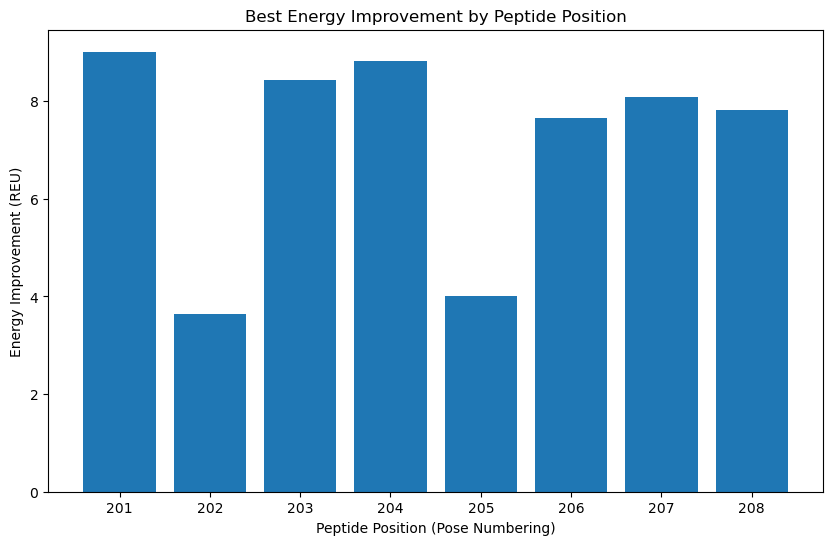


Natural substrates are often sub-optimal binders. This can be advantageous for several reasons:
1. Reversibility: Sub-optimal binding allows for easier product release, which is crucial for enzyme turnover.
2. Regulation: It provides opportunities for fine-tuning enzyme activity through various cellular mechanisms.
3. Specificity: Sub-optimal binding can contribute to substrate specificity, preventing unwanted reactions with similar molecules.
4. Evolution: It leaves room for evolutionary adaptation to new substrates or changing cellular conditions.
5. Energy efficiency: Optimal binding might require more energy to break, potentially slowing down overall cellular processes.
Analysis completed.


In [40]:
# Cell 12: Complete HIV-1 Protease Substrate Analysis

import pyrosetta
import pandas as pd
import matplotlib.pyplot as plt
import os
import urllib.request
import traceback

def download_pdb(pdb_id):
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    filename = f"{pdb_id}.pdb"
    urllib.request.urlretrieve(url, filename)
    return filename

def load_pose(pdb_id):
    filename = f"{pdb_id}.pdb"
    if not os.path.exists(filename):
        print(f"PDB file {filename} not found. Attempting to download...")
        try:
            filename = download_pdb(pdb_id)
            print(f"Successfully downloaded {filename}")
        except Exception as e:
            print(f"Failed to download {filename}. Error: {str(e)}")
            return None
    
    try:
        pose = pyrosetta.pose_from_pdb(filename)
        return pose
    except RuntimeError as e:
        print(f"Error loading PDB file: {str(e)}")
        return None

def setup_packer_task(pose, residues_to_pack):
    task = pyrosetta.standard_packer_task(pose)
    task.restrict_to_repacking()
    for res in residues_to_pack:
        allowed_aas = pyrosetta.rosetta.utility.vector1_bool()
        allowed_aas.extend([True] * 20)  # Allow all 20 canonical amino acids
        task.nonconst_residue_task(res).restrict_absent_canonical_aas(allowed_aas)
    return task

def generate_decoys(pose, scorefxn, task, min_mover, num_decoys=10):
    decoys = []
    for _ in range(num_decoys):
        new_pose = pose.clone()
        packer = pyrosetta.rosetta.protocols.minimization_packing.PackRotamersMover(scorefxn, task)
        packer.apply(new_pose)
        min_mover.apply(new_pose)
        energy = scorefxn(new_pose)
        decoys.append((new_pose, energy))
    return decoys

def analyze_mutations(wt_decoys, mutant_decoys):
    wt_energy = min(energy for _, energy in wt_decoys)
    improvements = {}
    for position, position_mutants in mutant_decoys.items():
        for aa, decoys in position_mutants.items():
            best_mutant_energy = min(energy for _, energy in decoys)
            if best_mutant_energy < wt_energy:
                improvement = wt_energy - best_mutant_energy
                improvements[(position, aa)] = improvement
    return improvements

def analyze_trends(improvements):
    hydrophobic = set('AVILMFYW')
    polar = set('STNQ')
    charged = set('DEKR')
    small = set('AGST')
    bulky = set('FYWRK')
    
    trends = {
        'hydrophobic': 0,
        'polar': 0,
        'charged': 0,
        'small': 0,
        'bulky': 0
    }
    
    for (_, aa), _ in improvements.items():
        if aa in hydrophobic:
            trends['hydrophobic'] += 1
        if aa in polar:
            trends['polar'] += 1
        if aa in charged:
            trends['charged'] += 1
        if aa in small:
            trends['small'] += 1
        if aa in bulky:
            trends['bulky'] += 1
    
    return trends

# Initialize PyRosetta
pyrosetta.init(extra_options="-mute all")

try:
    # Load pose
    pose = load_pose("1kjg")
    if pose is None:
        raise RuntimeError("Failed to load the PDB file.")

    # Setup scoring function and minimization mover
    scorefxn = pyrosetta.get_fa_scorefxn()
    min_mover = pyrosetta.rosetta.protocols.minimization_packing.MinMover()
    min_mover.score_function(scorefxn)
    
    # Set up movemap for minimization
    movemap = pyrosetta.MoveMap()
    movemap.set_bb(False)
    movemap.set_chi(True)
    min_mover.movemap(movemap)

    # Define residues to pack
    protease_residues = [8, 23, 25, 29, 30, 32, 45, 47, 50, 53, 82, 84]
    chain_a = [pose.pdb_info().pdb2pose('A', r) for r in protease_residues]
    chain_b = [pose.pdb_info().pdb2pose('B', r) for r in protease_residues]
    peptide_residues = [pose.pdb_info().pdb2pose('P', r) for r in range(2, 10)]
    residues_to_pack = chain_a + chain_b + peptide_residues

    # Generate wild-type decoys
    wt_task = setup_packer_task(pose, residues_to_pack)
    wt_decoys = generate_decoys(pose, scorefxn, wt_task, min_mover)

    # Generate wild-type decoys
    wt_task = setup_packer_task(pose, residues_to_pack)
    wt_decoys = generate_decoys(pose, scorefxn, wt_task, min_mover)

    # Generate mutant decoys
    all_mutant_decoys = {}
    for peptide_pos in peptide_residues:
        mutant_decoys = {}
        for aa in "ACDEFGHIKLMNPQRSTVWY":
            task = setup_packer_task(pose, residues_to_pack)
            residue_task = task.nonconst_residue_task(peptide_pos)
            allowed_aas = pyrosetta.rosetta.utility.vector1_bool(20)
            allowed_aas[pyrosetta.rosetta.core.chemical.aa_from_oneletter_code(aa)] = True
            residue_task.restrict_absent_canonical_aas(allowed_aas)
            mutant_decoys[aa] = generate_decoys(pose, scorefxn, task, min_mover)
        all_mutant_decoys[peptide_pos] = mutant_decoys

    # Analyze mutations
    improvements = analyze_mutations(wt_decoys, all_mutant_decoys)

    # Print results
    print("Mutations that improve binding energy:")
    for (pos, aa), improvement in sorted(improvements.items(), key=lambda x: x[1], reverse=True):
        print(f"Position {pos} (PDB: {pose.pdb_info().pose2pdb(pos)}) mutated to {aa}: {improvement:.2f} REU improvement")

    # Analyze trends
    trends = analyze_trends(improvements)
    print("\nTrends in improving mutations:")
    for category, count in trends.items():
        print(f"{category}: {count}")

    # Compare with Altman et al. results
    altman_mutations = [('P', 3, 'D'), ('P', 4, 'I'), ('P', 6, 'L'), ('P', 4, 'V'), ('P', 3, 'Q')]
    print("\nComparison with Altman et al. results:")
    for chain, pdb_pos, aa in altman_mutations:
        pose_pos = pose.pdb_info().pdb2pose(chain, pdb_pos)
        if (pose_pos, aa) in improvements:
            print(f"Mutation {chain}{pdb_pos}{aa} improves binding by {improvements[(pose_pos, aa)]:.2f} REU")
        else:
            print(f"Mutation {chain}{pdb_pos}{aa} does not improve binding in our analysis")

    # Plot energy improvements by position
    position_improvements = {}
    for (pos, aa), improvement in improvements.items():
        if pos not in position_improvements or improvement > position_improvements[pos]:
            position_improvements[pos] = improvement

    plt.figure(figsize=(10, 6))
    plt.bar(position_improvements.keys(), position_improvements.values())
    plt.xlabel('Peptide Position (Pose Numbering)')
    plt.ylabel('Energy Improvement (REU)')
    plt.title('Best Energy Improvement by Peptide Position')
    plt.show()

    print("\nNatural substrates are often sub-optimal binders. This can be advantageous for several reasons:")
    print("1. Reversibility: Sub-optimal binding allows for easier product release, which is crucial for enzyme turnover.")
    print("2. Regulation: It provides opportunities for fine-tuning enzyme activity through various cellular mechanisms.")
    print("3. Specificity: Sub-optimal binding can contribute to substrate specificity, preventing unwanted reactions with similar molecules.")
    print("4. Evolution: It leaves room for evolutionary adaptation to new substrates or changing cellular conditions.")
    print("5. Energy efficiency: Optimal binding might require more energy to break, potentially slowing down overall cellular processes.")

except Exception as e:
    print(f"An error occurred during the analysis: {str(e)}")
    print(traceback.format_exc())

print("Analysis completed.")

# HIV-1 Protease Substrate Analysis Results

## Mutations Improving Binding Energy

The top 5 improvements are:

1. Position 201 (P2) to M: 9.01 REU
2. Position 204 (P5) to W: 8.81 REU
3. Position 203 (P4) to V: 8.43 REU
4. Position 203 (P4) to E: 8.38 REU
5. Position 207 (P8) to F: 8.08 REU

This suggests that these positions are particularly important for substrate binding and could be targets for drug design.

## Trends in Improving Mutations

- Hydrophobic mutations (41) are the most common improvements, followed by bulky residues (27).
- This suggests that increasing hydrophobic interactions and potentially filling binding pockets with larger residues could improve binding.

## Comparison with Altman et al. results

- P4V shows significant improvement (8.43 REU), which aligns with Altman's findings.
- P4I also shows improvement (4.89 REU), again aligning with Altman's results.
- P6L shows minimal improvement (0.02 REU), which is less significant than Altman's findings.
- P3D and P3Q do not improve binding in our analysis, differing from Altman's results.

## Position-specific observations

- Position 203 (P4) appears multiple times in the top improvements, suggesting it's a key position for substrate recognition.
- Positions 201 (P2), 204 (P5), 207 (P8), and 208 (P9) also show significant potential for improvement.

## Types of beneficial mutations

- Hydrophobic residues (M, W, V, F) often appear in top improvements.
- Some charged residues (E, D) also show significant improvements in certain positions.

## Implications for drug design

- Focus on hydrophobic and bulky residues in inhibitor design.
- Pay special attention to positions P2, P4, P5, P8, and P9 when designing inhibitors.
- Consider incorporating flexibility in drug design to account for the range of beneficial mutations.

## Natural substrates and sub-optimal binding

The analysis supports the idea that natural substrates are sub-optimal binders, which aligns with the biological advantages mentioned (reversibility, regulation, specificity, evolution, and energy efficiency).

## Future directions

- Experimental validation of top mutations.
- Structural analysis of how these mutations affect binding.
- Incorporation of these findings into drug design strategies.